<a href="https://colab.research.google.com/github/ekm507/iranian-name-generation/blob/main/iranian_name_Generation_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

model is the same as MIT 6.s191 model for music generation

In [ ]:
license: GPLv3

## 2.1 Dependencies 
First, let's download the course repository, install dependencies, and import the relevant packages we'll need for this lab.

In [ ]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf 

# Download and import the MIT 6.S191 package
!pip install mitdeeplearning
import mitdeeplearning as mdl

# Import all remaining packages
import numpy as np
import os
import time
import requests
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
!apt-get install abcmidi timidity > /dev/null 2>&1

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 4.8 MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.2.0-py3-none-any.whl size=2115442 sha256=44422e83a9d9b8535158893307ebb357297079fa980cfc49b522d4dd92a78ea3
  Stored in directory: /root/.cache/pip/wheels/9a/b9/4f/99b7c8c5c75355550b83e1fcfc02956fb40c35eb01e2262877
Successfully built mitdeeplearning


## 2.2 Dataset

dataset is collected from this repo for persian words: http://github.com/behnam/persian-words-frequency

(not used in this notebook)

In [ ]:
persian_words_text = requests.get('https://raw.githubusercontent.com/behnam/persian-words-frequency/master/persian-wikipedia.txt').text
words = []
lines = persian_words_text.split('#')[-1].split('\n')
words = [line.split('\t')[0] for line in lines[1:-1]]

characters = set(''.join(words)+' ')
code_to_character = dict(enumerate(characters))
character_to_code = {y: x for x, y in code_to_character.items()}
print(character_to_code)
code_size = len(characters)

def encode_text(text):
  return [character_to_code[character] for character in text]

def decode_text(number_list):
  return ''.join([code_to_character[code] for code in number_list])

encoded_words = [encode_text(word) for word in words]
# encoded_words = np.array(encoded_words)

full_text = ' '.join(words)
encoded_full_text = np.array(encode_text(full_text))
print(len(encoded_full_text))

{'آ': 0, 'ژ': 1, 'ّ': 2, 'ظ': 3, '‐': 4, 'ٱ': 5, 'ز': 6, 'گ': 7, 'ْ': 8, 'ة': 9, 'ص': 10, 'ک': 11, 'َ': 12, 'ب': 13, 'س': 14, 'ى': 15, 'د': 16, 'و': 17, 'ٌ': 18, 'ٔ': 19, 'ح': 20, 'ۀ': 21, 'ً': 22, 'ط': 23, 'ع': 24, 'ٰ': 25, 'م': 26, 'چ': 27, 'ش': 28, 'ث': 29, 'ض': 30, 'ل': 31, 'ق': 32, 'أ': 33, 'ی': 34, '\u200c': 35, 'غ': 36, 'ف': 37, 'ر': 38, ' ': 39, 'ت': 40, 'ن': 41, 'ٍ': 42, 'ؤ': 43, 'ك': 44, 'پ': 45, 'ذ': 46, 'ء': 47, 'ج': 48, 'إ': 49, 'ئ': 50, 'ا': 51, 'ِ': 52, 'ي': 53, 'ُ': 54, 'ه': 55, '\u200d': 56, 'خ': 57, 'ٓ': 58}
3260895



dataset is collected from this repo for persian names: https://github.com/peymanslh/persian-gender-detection/

In [ ]:
iranian_names_csv = requests.get('https://raw.githubusercontent.com/peymanslh/persian-gender-detection/master/gender/names.csv').text
persian_names = [line.split(',')[0] for line in iranian_names_csv.split('\n')[1:]]

full_text = ' '.join(persian_names)

characters = set(full_text)
code_to_character = dict(enumerate(characters))
character_to_code = {y: x for x, y in code_to_character.items()}

code_size = len(characters)

def encode_text(text):
  return [character_to_code[character] for character in text]

def decode_text(number_list):
  return ''.join([code_to_character[code] for code in number_list])

encoded_full_text = np.array(encode_text(full_text))


print(len(persian_names))
print(persian_names[:10])
print(len(encoded_full_text))

6175
['اَبدَه', 'اَبیش', 'اَپروَند', 'اَپروَیژ', 'اَپیوه', 'اَترس', 'اَدرك', 'اَرتان', 'اَردویسور', 'اَرشَن']
40108


## 2.3 Process the dataset for the learning task

Let's take a step back and consider our prediction task. We're trying to train a RNN model to learn patterns in ABC music, and then use this model to generate (i.e., predict) a new piece of music based on this learned information. 

Breaking this down, what we're really asking the model is: given a character, or a sequence of characters, what is the most probable next character? We'll train the model to perform this task. 

To achieve this, we will input a sequence of characters to the model, and train the model to predict the output, that is, the following character at each time step. RNNs maintain an internal state that depends on previously seen elements, so information about all characters seen up until a given moment will be taken into account in generating the prediction.

### Vectorize the text

Before we begin training our RNN model, we'll need to create a numerical representation of our text-based dataset. To do this, we'll generate two lookup tables: one that maps characters to numbers, and a second that maps numbers back to characters. Recall that we just identified the unique characters present in the text.

### Create training examples and targets

Our next step is to actually divide the text into example sequences that we'll use during training. Each input sequence that we feed into our RNN will contain `seq_length` characters from the text. We'll also need to define a target sequence for each input sequence, which will be used in training the RNN to predict the next character. For each input, the corresponding target will contain the same length of text, except shifted one character to the right.

To do this, we'll break the text into chunks of `seq_length+1`. Suppose `seq_length` is 4 and our text is "Hello". Then, our input sequence is "Hell" and the target sequence is "ello".

The batch method will then let us convert this stream of character indices to sequences of the desired size.

In [ ]:
print(len(encoded_full_text))

3260895


In [ ]:
### Batch definition to create training examples ###

def get_batch(encoded_full_text, seq_length, batch_size):
  # the length of the vectorized songs string
  n = encoded_full_text.shape[0] - 1
  # randomly choose the starting indices for the examples in the training batch
  idx = np.random.choice(n-seq_length*2, batch_size)

  idx_space = []
  for idx in idx:
    for i in range(idx, idx + 30):
      if full_text[i] == ' ':
        break
    idx_space.append(i)
  


  '''TODO: construct a list of input sequences for the training batch'''
  input_batch = np.array([encoded_full_text[q:q+seq_length] for q in idx_space])
  '''TODO: construct a list of output sequences for the training batch'''
  output_batch = np.array([encoded_full_text[q+1:q+seq_length+1] for q in idx_space])
  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch


# Perform some simple tests to make sure your batch function is working properly! 
test_args = (encoded_full_text, 10, 2)


In [ ]:
def get_batch2(encoded_words, seq_length, batch_size):

  words_ids = np.random.choice(len(encoded_words), batch_size)
  words = [encoded_words[id][:seq_length] for id in words_ids]
  # words = np.array([word for word in words])

  # print(words)

  space_code = encode_text(' ')

  # input_batch = np.array([word[:-1] for word in words])
  # output_batch = np.array([word[1:] for word in words])
  input_batch = [word[:-1] + space_code * (seq_length - len(word)) for word in words]
  output_batch = [word[1:] + space_code * (seq_length - len(word)) for word in words]
  # output_batch = [word[1:] for word in words]
  # x_batch, y_batch provide the true inputs and targets for network training
  # x_batch = np.reshape(input_batch, [batch_size, seq_length])
  # y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return np.array(input_batch), np.array(output_batch)

get_batch2(encoded_words, 20, 2)

(array([[17,  0, 34, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
         39, 39, 39],
        [11, 17, 38, 34, 41, 40, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
         39, 39, 39]]),
 array([[ 0, 34, 40, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
         39, 39, 39],
        [17, 38, 34, 41, 40, 17, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
         39, 39, 39]]))

In [ ]:
def get_batch3(encoded_full_text, seq_length, batch_size):
  # the length of the vectorized songs string
  n = len(encoded_full_text) - 1
  # randomly choose the starting indices for the examples in the training batch
  idx = np.random.choice(n-seq_length, batch_size)

  idx_space = []
  idx_last = []
  for idx in idx:
    j = idx + seq_length
    for i in range(idx, idx + 30):
      if full_text[i] == ' ':
        for j in range(i + 1, i+30):
          if full_text[j] == ' ':
            break
        break
    idx_space.append(i)
    idx_last.append(j)
  
  # print(idx_space)
  # print(idx_last)
  # idx_space_clip = [word.split(' ') + ' ' * (seq_length - len(word.split(' '))) for word in idx_space]
  
  p = [(i, j) for i, j in zip(idx_space, idx_last)]
  q = [[5] * (seq_length - j + i) for i, j in p]
  # print(q)

  input_batch = np.array([np.array(
      encoded_full_text[i:j] + [5] * (seq_length - j + i))
      for i, j in zip(idx_space, idx_last)])
  
  # print(input_batch)
  output_batch = np.array([np.array(
      encoded_full_text[i+1:j+1] + [5] * (seq_length - j + i))
      for i, j in zip(idx_space, idx_last)])
  # output_batch = np.array([encoded_full_text[q+1:q+seq_length+1] for q in idx_space])
  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch


get_batch3(encoded_full_text, 10, 2)


ValueError: ignored

In [ ]:
print(test_args)
print(len(get_batch(encoded_full_text, 10, 2)[1]))
print(get_batch(encoded_full_text, 10, 2)[1])

(array([17, 14, 38, ..., 10, 17, 37]), 10, 2)
2
[[17 21 28  6 17 37 17 21 28  6]
 [ 2 18  6 19 26 37  2 22 17  3]]


For each of these vectors, each index is processed at a single time step. So, for the input at time step 0, the model receives the index for the first character in the sequence, and tries to predict the index of the next character. At the next timestep, it does the same thing, but the RNN considers the information from the previous step, i.e., its updated state, in addition to the current input.

We can make this concrete by taking a look at how this works over the first several characters in our text:

In [ ]:
x_batch, y_batch = get_batch(encoded_full_text, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(decode_text([input_idx]))))
    print("  expected output: {} ({:s})".format(target_idx, repr(decode_text([target_idx]))))

Step   0
  input: 37 (' ')
  expected output: 17 ('ا')
Step   1
  input: 17 ('ا')
  expected output: 38 ('ب')
Step   2
  input: 38 ('ب')
  expected output: 21 ('و')
Step   3
  input: 21 ('و')
  expected output: 17 ('ا')
Step   4
  input: 17 ('ا')
  expected output: 19 ('ل')


## 2.4 The Recurrent Neural Network (RNN) model

Now we're ready to define and train a RNN model on our ABC music dataset, and then use that trained model to generate a new song. We'll train our RNN using batches of song snippets from our dataset, which we generated in the previous section.

The model is based off the LSTM architecture, where we use a state vector to maintain information about the temporal relationships between consecutive characters. The final output of the LSTM is then fed into a fully connected [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer where we'll output a softmax over each character in the vocabulary, and then sample from this distribution to predict the next character. 

As we introduced in the first portion of this lab, we'll be using the Keras API, specifically, [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential), to define the model. Three layers are used to define the model:

* [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): This is the input layer, consisting of a trainable lookup table that maps the numbers of each character to a vector with `embedding_dim` dimensions.
* [`tf.keras.layers.LSTM`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): Our LSTM network, with size `units=rnn_units`. 
* [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): The output layer, with `vocab_size` outputs.


<img src="https://raw.githubusercontent.com/aamini/introtodeeplearning/2019/lab1/img/lstm_unrolled-01-01.png" alt="Drawing"/>

### Define the RNN model

Now, we will define a function that we will use to actually build the model.

In [ ]:
def LSTM(rnn_units): 
  return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

The time has come! Fill in the `TODOs` to define the RNN model within the `build_model` function, and then call the function you just defined to instantiate the model!

In [ ]:
### Defining the RNN Model ###

'''TODO: Add LSTM and Dense layers to define the RNN model using the Sequential API.'''
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    # Layer 1: Embedding layer to transform indices into dense vectors 
    #   of a fixed embedding size
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    # Layer 2: LSTM with `rnn_units` number of units. 
    # TODO: Call the LSTM function defined above to add this layer.
    LSTM(rnn_units),

    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
    #   into the vocabulary size. 
    # TODO: Add the Dense layer.
    # '''TODO: DENSE LAYER HERE'''
    tf.keras.layers.Dense(units = vocab_size)
  ])

  return model

# Build a simple model with default hyperparameters. You will get the 
#   chance to change these later.
model = build_model(code_size, embedding_dim=256, rnn_units=1024, batch_size=32)

### Test out the RNN model

It's always a good idea to run a few simple checks on our model to see that it behaves as expected.  

First, we can use the `Model.summary` function to print out a summary of our model's internal workings. Here we can check the layers in the model, the shape of the output of each of the layers, the batch size, etc.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (32, None, 256)           11008     
                                                                 
 lstm (LSTM)                 (32, None, 1024)          5246976   
                                                                 
 dense (Dense)               (32, None, 43)            44075     
                                                                 
Total params: 5,302,059
Trainable params: 5,302,059
Non-trainable params: 0
_________________________________________________________________


We can also quickly check the dimensionality of our output, using a sequence length of 100. Note that the model can be run on inputs of any length.

In [ ]:
x, y = get_batch(encoded_full_text, seq_length=100, batch_size=32)
# print(np.shape(y), np.shape(pred))
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       (32, 100)  # (batch_size, sequence_length)
Prediction shape:  (32, 100, 43) # (batch_size, sequence_length, vocab_size)


### Predictions from the untrained model

Let's take a look at what our untrained model is predicting.

To get actual predictions from the model, we sample from the output distribution, which is defined by a `softmax` over our character vocabulary. This will give us actual character indices. This means we are using a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) to sample over the example prediction. This gives a prediction of the next character (specifically its index) at each timestep.

Note here that we sample from this probability distribution, as opposed to simply taking the `argmax`, which can cause the model to get stuck in a loop.

Let's try this sampling out for the first example in the batch.

In [ ]:
sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

array([21,  1, 28, 31,  7,  5, 19,  2, 12, 10, 22, 16, 16, 38, 17,  2, 38,
       20,  9,  4, 34,  5, 37, 29, 13,  7, 31, 27,  4, 28, 25,  9, 12, 36,
       31, 21, 41, 29, 12,  3,  3, 29, 20,  2, 21, 19, 13, 10,  1, 18, 28,
       38,  8, 36, 10,  9,  8,  2, 23,  1, 19, 14, 38, 39, 17, 10,  7, 19,
       41, 24, 15, 27,  1, 38, 28,  0, 31, 21, 31, 29, 12, 26, 11, 25, 14,
       21,  4, 19, 27, 22,  5, 30,  6,  9, 39,  2,  0, 23, 33, 32])

We can now decode these to see the text predicted by the untrained model:

In [ ]:
# print("Input: \n", repr("".join(idx2char[x[0]])))
print(decode_text(x[0]))
print(decode_text(sampled_indices))

# print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

 باپیر باپیو باتوف باتیس باتینك باتینوك بادام بادامك بادان بادر بادرام بادلیس بادینان باذان باراد با
وگرطْجلفحدغصصبافبءژذؤج كزْطُذرخژحظطوةكحننكءفولزدگضربسظدژسفقگلَبأادْلةچپُگبرمطوطكحتِخَوذلُغجشیژأفمقئث


As you can see, the text predicted by the untrained model is pretty nonsensical! How can we do better? We can train the network!

## 2.5 Training the model: loss and training operations

Now it's time to train the model!

At this point, we can think of our next character prediction problem as a standard classification problem. Given the previous state of the RNN, as well as the input at a given time step, we want to predict the class of the next character -- that is, to actually predict the next character. 

To train our model on this classification task, we can use a form of the `crossentropy` loss (negative log likelihood loss). Specifically, we will use the [`sparse_categorical_crossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy) loss, as it utilizes integer targets for categorical classification tasks. We will want to compute the loss using the true targets -- the `labels` -- and the predicted targets -- the `logits`.

Let's first compute the loss using our example predictions from the untrained model: 

In [ ]:
### Defining the loss function ###

'''TODO: define the loss function to compute and return the loss between
    the true labels and predictions (logits). Set the argument from_logits=True.'''
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True) # TODO
  return loss

'''TODO: compute the loss using the true next characters from the example batch 
    and the predictions from the untrained model several cells above'''
example_batch_loss = compute_loss(y, pred) # TODO

print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 100, 43)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       3.7616022


Let's start by defining some hyperparameters for training the model. To start, we have provided some reasonable values for some of the parameters. It is up to you to use what we've learned in class to help optimize the parameter selection here!

In [ ]:
### Hyperparameter setting and optimization ###

# Optimization parameters:
num_training_iterations = 5_000  # Increase this to train longer
batch_size = 16  # Experiment between 1 and 64
seq_length = 20  # Experiment between 50 and 500
learning_rate = 1e-2  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = code_size
embedding_dim = 256 
rnn_units = 1024 # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

Now, we are ready to define our training operation -- the optimizer and duration of training -- and use this function to train the model. You will experiment with the choice of optimizer and the duration for which you train your models, and see how these changes affect the network's output. Some optimizers you may like to try are [`Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam?version=stable) and [`Adagrad`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adagrad?version=stable).

First, we will instantiate a new model and an optimizer. Then, we will use the [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape) method to perform the backpropagation operations. 

We will also generate a print-out of the model's progress through training, which will help us easily visualize whether or not we are minimizing the loss.

In [ ]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (16, None, 256)           11008     
                                                                 
 lstm_1 (LSTM)               (16, None, 1024)          5246976   
                                                                 
 dense_1 (Dense)             (16, None, 43)            44075     
                                                                 
Total params: 5,302,059
Trainable params: 5,302,059
Non-trainable params: 0
_________________________________________________________________


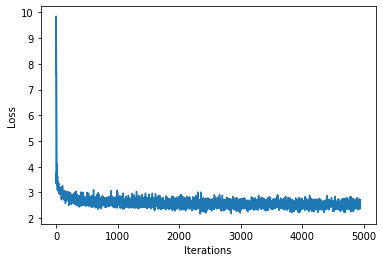

100%|██████████| 5000/5000 [00:49<00:00, 100.67it/s]


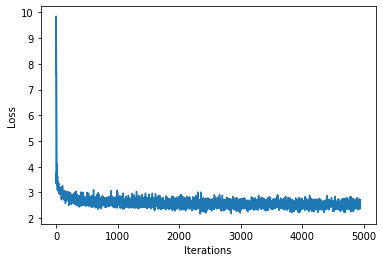

In [ ]:
### Define optimizer and training operation ###

'''TODO: instantiate a new model for training using the `build_model`
  function and the hyperparameters created above.'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)

'''TODO: instantiate an optimizer with its learning rate.
  Checkout the tensorflow website for a list of supported optimizers.
  https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/
  Try using the Adam optimizer to start.'''
optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def train_step(x, y): 
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:
  
    '''TODO: feed the current input into the model and generate predictions'''
    y_hat = model(x)
  
    '''TODO: compute the loss!'''
    loss = compute_loss(y, y_hat)

  # Now, compute the gradients 
  '''TODO: complete the function call for gradient computation. 
      Remember that we want the gradient of the loss with respect all 
      of the model parameters. 
      HINT: use `model.trainable_variables` to get a list of all model
      parameters.'''
  grads = tape.gradient(loss, model.trainable_variables)
  
  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

##################
# Begin training!#
##################

history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(encoded_full_text, seq_length, batch_size)
  # x_batch, y_batch = get_batch2(encoded_words, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)
  
  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 1000 == 0:     
    model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)


## 2.6 Generate music using the RNN model

Now, we can use our trained RNN model to generate some music! When generating music, we'll have to feed the model some sort of seed to get it started (because it can't predict anything without something to start with!).

Once we have a generated seed, we can then iteratively predict each successive character (remember, we are using the ABC representation for our music) using our trained RNN. More specifically, recall that our RNN outputs a `softmax` over possible successive characters. For inference, we iteratively sample from these distributions, and then use our samples to encode a generated song in the ABC format.

Then, all we have to do is write it to a file and listen!

### Restore the latest checkpoint

To keep this inference step simple, we will use a batch size of 1. Because of how the RNN state is passed from timestep to timestep, the model will only be able to accept a fixed batch size once it is built. 

To run the model with a different `batch_size`, we'll need to rebuild the model and restore the weights from the latest checkpoint, i.e., the weights after the last checkpoint during training:

In [ ]:
'''TODO: Rebuild the model using a batch_size=1'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (1, None, 256)            11008     
                                                                 
 lstm_6 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_6 (Dense)             (1, None, 43)             44075     
                                                                 
Total params: 5,302,059
Trainable params: 5,302,059
Non-trainable params: 0
_________________________________________________________________


Notice that we have fed in a fixed `batch_size` of 1 for inference.

### The prediction procedure

Now, we're ready to write the code to generate text in the ABC music format:

* Initialize a "seed" start string and the RNN state, and set the number of characters we want to generate.

* Use the start string and the RNN state to obtain the probability distribution over the next predicted character.

* Sample from multinomial distribution to calculate the index of the predicted character. This predicted character is then used as the next input to the model.

* At each time step, the updated RNN state is fed back into the model, so that it now has more context in making the next prediction. After predicting the next character, the updated RNN states are again fed back into the model, which is how it learns sequence dependencies in the data, as it gets more information from the previous predictions.

![LSTM inference](https://raw.githubusercontent.com/aamini/introtodeeplearning/2019/lab1/img/lstm_inference.png)

Complete and experiment with this code block (as well as some of the aspects of network definition and training!), and see how the model performs. How do songs generated after training with a small number of epochs compare to those generated after a longer duration of training?

In [ ]:
### Prediction of a generated song ###

def generate_text(model, start_string, generation_length=1000):
  # Evaluation step (generating ABC text using the learned RNN model)

  '''TODO: convert the start string t
The executing code is not responding to interrupts. Would you like to try restarting the runtime? Runtime state including all local variables will be lost.
o numbers (vectorize)'''
  input_eval = encode_text(start_string)
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      '''TODO: evaluate the inputs and generate the next character predictions'''
      predictions = model(input_eval)
      
      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)
      
      '''TODO: use a multinomial distribution to sample'''
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      
      # Pass the prediction along with the previous hidden state
      #   as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)
      
      '''TODO: add the predicted character to the generated text!'''
      # Hint: consider what format the prediction is in vs. the output
      text_generated.append(predicted_id)
    
  return (start_string + decode_text(text_generated))

In [ ]:
'''TODO: Use the model and the function defined above to generate ABC format text of length 1000!
    As you may notice, ABC files start with "X" - this may be a good start string.'''
generated_text = '\n'.join([generate_text(model, start_string=" ", generation_length=100) for _ in range(10)]) # TODO
# generated_text = generate_text('''TODO''', start_string="X", generation_length=1000)
print()
print(generated_text)

100%|██████████| 100/100 [00:00<00:00, 162.05it/s]


 بوواكل یخوشارون یدادان آتان حارنوش ناتونا صلدادله سپوشت آپندختك وهروتك منمس شرزاقین نیلوت برشان ماهو
 آقمتوتها محمانوا واقلهر مهالل دوروامه نوتخت فروتح فرتو نارقی بادله تواوده اویره پوشان چوتست خرفراراه
 لهانوالدومارتون كواون روگل ورمكو مهاءار دل سپینوت شارسانرنداله كخت دلافخت آدیس پساساساكل عبدخت سامین
 آپونوام تاوسا اتالده صغوروان فصهیره ختیل ندخت اكواسه صندل مقادالله زانوش شادان شهاد باناز تقدخت ارین
 ظعحماناز خوالن مویندان پارحده تانر فرا هلوان فرشسپناه پالعنون نوشالدك شروین شاراینه قاماللیت برداونر
 گانینوزمینه ال دلالحو ققمكانه واونا بنی ادكون نوهونه امن نسات اممام بانیاد كاوق شهرین فرینون محیا هو
 قیاسنسان افروا مقفلبدخت قوران صلكون ققاارتكار كیكو شال بانو یلست پوتویاد آراون مهوكاهوش بروا شهرووان
 آیاوتپاداللتونرسام شیصدین شال كوتنوت وائان شارفراقدیس نارنوا فوراونسانونده نت امیون خیلین سیت پاپوا 
 گونالاللهان حوتان وهال شینكون كلقان رخسدین شهنو مهراریلوهله نوه خوناد پرواردی ماتن لیلین كیتالله اَر
 آاواوشودناهوالكالله پندان رخان كلین شستانین نوپوندن تونیندكا هیزال چهریكوان تودا